In [1]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
from oma_spec import gen_mag_spectrogram_mod
from scipy.ndimage.interpolation import zoom
import cPickle as pickle
import os
import librosa
base = '/media/michael/Seagate/engage/urban8k/'
metadata = pd.read_csv(base + '/UrbanSound8K/metadata/UrbanSound8K.csv')

# os.makedirs(base + 'specs_librosa')

/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import pandas as pd

def _extract_segments(args):
    clip, filename, fold, category, category_name, augmented, frames = args

    # Due to an off-by-one bug which has not been caught earlier,
    # actually both variants (long and short) use the same
    # overlap setting (half of window size) - whereas different settings
    # were mentioned in the paper.
    #
    # The code below has been already cleaned up to reflect those changes.
    #
    # Apart from that, for reproducibility purposes it is required that
    # librosa v0.3.1 is used, as further versions drastically change
    # the delta computations.
    
    FRAMES_PER_SEGMENT = frames - 1  # 41 frames ~= 950 ms segment length @ 22050 Hz
    WINDOW_SIZE = 512 * FRAMES_PER_SEGMENT   # 23 ms per frame @ 22050 Hz
    STEP_SIZE = 512 * FRAMES_PER_SEGMENT // 2
    BANDS = 60
    
    s = 0
    segments = []

    normalization_factor = 1 / np.max(np.abs(clip)) 
    clip = clip * normalization_factor

    while len(clip[s * STEP_SIZE:s * STEP_SIZE + WINDOW_SIZE]) == WINDOW_SIZE:
        signal = clip[s * STEP_SIZE:s * STEP_SIZE + WINDOW_SIZE]

        melspec = librosa.feature.melspectrogram(signal, sr=22050, n_fft=1024, hop_length=512, n_mels=BANDS)
        logspec = librosa.logamplitude(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        logspec = pd.DataFrame(data=logspec, dtype='float32', index=[0], columns=list('logspec_b{}_f{}'.format(i % BANDS, i / BANDS) for i in range(np.shape(logspec)[1])))

        if np.mean(logspec.as_matrix()) > -70.0:   # drop silent frames
            segment_meta = pd.DataFrame({'filename': filename, 'fold': fold, 'category': category, 'category_name': category_name,
                                        's_begin': s * STEP_SIZE, 's_end': s * STEP_SIZE + WINDOW_SIZE, 'augmented': augmented}, index=[0])
            segments.append(pd.concat((segment_meta, logspec), axis=1))
        s = s + 1

    print len(segments)
    print segments[0].shape
    print segments[1].shape
    segments = pd.concat(segments, ignore_index=True)
    return segments

In [9]:
required_height = 224
SAMPLERATE = 22050
N_FFT = 2048
HOP_LENGTH = 1024 # 512
N_MELS = 32 # 128
n_samples = SAMPLERATE * 4 # each clip is padded to 4 seconds (the maximal length)

for fold in range(1, 11):
    X = []
    fold_meta = metadata[metadata['fold'] == fold]

    for row in fold_meta.iterrows():    
        loadpath = base + 'UrbanSound8K/audio/fold%d/%s' % (
            row[1]['fold'], row[1]['slice_file_name'])

        # reading wav and force mono
        y, sr = librosa.core.load(loadpath, sr=SAMPLERATE, mono=True)
        y = y[:n_samples] # truncate to max length of 4 seconds if necessary
        
        y_padded = np.zeros((n_samples,), dtype='float32')
        offset = (n_samples - y.shape[0]) // 2
        y_padded[offset:offset + y.shape[0]] = y
        
        s = librosa.feature.melspectrogram(y_padded, sr=SAMPLERATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

        X.append(s)
        sds
#         # padding or cropping to required shape
#         if spec.shape[0] < required_height:
#             pad = np.zeros((required_height - spec.shape[0], spec.shape[1]))
#             spec = np.vstack((spec, pad))
#         elif spec.shape[0] > required_height:
#             spec = spec[:required_height]

#         # resizing
#         factor = (224.0/spec.shape[0], 224.0/spec.shape[1])
#         spec = zoom(spec, factor, order=1)
#         X.append(spec)

    # saving
    savepath = base + 'specs_librosa/fold%d.pkl' % fold
    tosave = {'X': X, 'classID': fold_meta['classID'], 'class': fold_meta['class']}
    pickle.dump(tosave, open(savepath, 'w'), -1)

NameError: name 'sds' is not defined

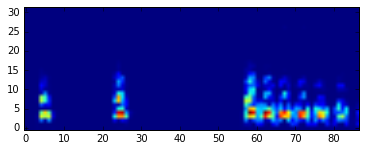

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(np.log(1+s))
plt.gca().invert_yaxis()